# Valuing a multi-asset, multi-region portfolio

In this training module we'll see how to use LUSID to perform the following task:

**<div align="center">As a portfolio manager with a mix of equities and bonds in different regions, I want to load market data from multiple providers and track the performance of my fund over time as prices and rates change.</div>**

In [1]:
# Set up LUSID
import os
import pandas as pd
import json
import uuid
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from datetime import datetime, timedelta
import logging
logging.basicConfig(level=logging.INFO)

import lusid as lu
import lusid.api as la
import lusid.models as lm

from lusid.utilities import ApiClientFactory
from lusidjam import RefreshingToken
from lusidtools.pandas_utils.lusid_pandas import lusid_response_to_data_frame
from lusidtools.jupyter_tools import StopExecution
from lusidtools.lpt.lpt import to_date

# Set pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = "{:,.2f}".format

# Set matplotlib display options
%matplotlib inline
plt.style.use('fivethirtyeight')

# Authenticate to SDK
# Run the Notebook in Jupyterhub for your LUSID domain and authenticate automatically
secrets_path = os.getenv("FBN_SECRETS_PATH")
# Run the Notebook locally using a secrets file (see https://support.lusid.com/knowledgebase/article/KA-01663)
if secrets_path is None:
    secrets_path = os.path.join(os.path.dirname(os.getcwd()), "secrets.json")

api_factory = ApiClientFactory(
    token = RefreshingToken(), 
    api_secrets_filename = secrets_path,
    app_name = "LusidJupyterNotebook"
)

# Confirm success by printing SDK version
api_status = pd.DataFrame(api_factory.build(lu.ApplicationMetadataApi).get_lusid_versions().to_dict())
display(api_status)

,api_version,build_version,excel_version,links
0,v0,0.6.10020.0,0.5.3017,"{'relation': 'RequestLogs', 'href': 'http://ja..."


In [2]:
# Create a scope and code to segregate data in this module from other modules
module_scope = "FBNUniversity"
module_code = "Module-4-1"
print(f"'{module_scope}\{module_code}' scope and code created.")

'FBNUniversity\Module-4-1' scope and code created.


## 1. Examining the source files

In [3]:
# Read transactions into Pandas dataframe (showing all the decimal places for the coupons)
with pd.option_context('display.float_format', '{:,.3f}'.format):
    transactions_df = pd.read_csv("data/transactions.csv")
    # Create a virtual 'cost' column to calculate price / par * units for bonds, and price * units for cash and equities
    transactions_df["cost"] = transactions_df.apply(
        lambda row: (row["units"] / row["par"] * row["price"] if row["class"] == "Bond" 
                     else row["units"] * row["price"]), axis = 1)
    display(transactions_df)

,instrument,class,figi,isin,txn_id,txn_type,settle_date,units,price,par,currency,coupon%,maturity,cost
0,GBP,Cash,NaN,NaN,MD41001,FundsIn,2022-03-07,100000,1.000,NaN,GBP,NaN,NaN,"100,000.000"
1,USD,Cash,NaN,NaN,MD41002,FundsIn,2022-03-07,30000,1.000,NaN,USD,NaN,NaN,"30,000.000"
2,BP,Equity,BBG000C05BD1,GB0007980591,MD41003,Buy,2022-03-07,2000,25.000,NaN,GBP,NaN,NaN,"50,000.000"
3,Microsoft,Equity,BBG000BPH459,US5949181045,MD41004,Buy,2022-03-07,1000,20.000,NaN,USD,NaN,NaN,"20,000.000"
4,UKT 0 ⅜ 10/22/26,Bond,BBG00ZF1T9P5,GB00BNNGP668,MD41005,Buy,2022-03-07,10000,98.000,100.000,GBP,0.375,2026-10-22,"9,800.000"
5,T 2.375% Aug 15 2024,Bond,BBG006XYRVX1,US912828D564,MD41006,Buy,2022-03-07,5000,104.000,100.000,USD,2.375,2024-8-15,"5,200.000"


,Asset,Figi,Date,Price,Currency
0,BP,BBG000C05BD1,03/07/2022,22.05,GBP
1,Microsoft,BBG000BPH459,03/07/2022,18.10,USD
2,BP,BBG000C05BD1,03/08/2022,20.25,GBP
3,Microsoft,BBG000BPH459,03/08/2022,22.12,USD
4,BP,BBG000C05BD1,03/09/2022,24.15,GBP
5,Microsoft,BBG000BPH459,03/09/2022,21.03,USD
6,BP,BBG000C05BD1,03/10/2022,26.95,GBP
7,Microsoft,BBG000BPH459,03/10/2022,24.08,USD
8,BP,BBG000C05BD1,03/11/2022,28.45,GBP
9,Microsoft,BBG000BPH459,03/11/2022,22.87,USD


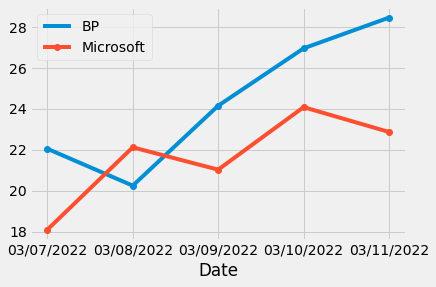

In [4]:
# Read 1 week of equity prices from EDI
equity_prices_df = pd.read_csv("data/edi.csv", keep_default_na = False)
display(equity_prices_df)

fig, ax = plt.subplots()
for label, grp in equity_prices_df.groupby("Asset"):
    grp.plot(x = "Date", y = "Price", ax = ax, label = label, marker = 'o')

,Asset,Isin,Date,Price,Currency
0,UKT 0 ⅜ 10/22/26,GB00BNNGP668,03/07/2022,101.20,GBP
1,T 2.375% Aug 15 2024,US912828D564,03/07/2022,103.00,USD
2,UKT 0 ⅜ 10/22/26,GB00BNNGP668,03/08/2022,97.65,GBP
3,T 2.375% Aug 15 2024,US912828D564,03/08/2022,105.10,USD
4,UKT 0 ⅜ 10/22/26,GB00BNNGP668,03/09/2022,99.40,GBP
5,T 2.375% Aug 15 2024,US912828D564,03/09/2022,109.00,USD
6,UKT 0 ⅜ 10/22/26,GB00BNNGP668,03/10/2022,103.70,GBP
7,T 2.375% Aug 15 2024,US912828D564,03/10/2022,106.00,USD
8,UKT 0 ⅜ 10/22/26,GB00BNNGP668,03/11/2022,101.44,GBP
9,T 2.375% Aug 15 2024,US912828D564,03/11/2022,103.00,USD


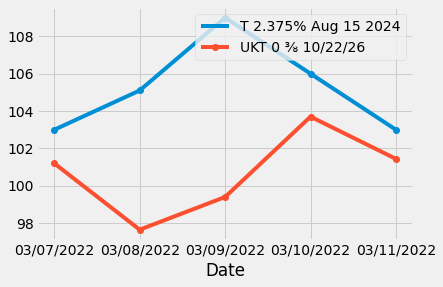

In [5]:
# Read 1 week of bond prices from Refinitiv Datascope
bond_prices_df = pd.read_csv("data/refinitiv.csv", keep_default_na = False)
display(bond_prices_df)

fig, ax = plt.subplots()
for label, grp in bond_prices_df.groupby("Asset"):
    grp.plot(x = "Date", y = "Price", ax = ax, label = label, marker = 'o')

,Currency,Date,Rate
0,USD/GBP,03-07-2022,0.70
1,USD/GBP,03-08-2022,0.74
2,USD/GBP,03-09-2022,0.71
3,USD/GBP,03-11-2022,0.76


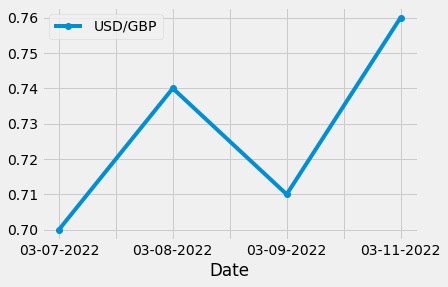

In [6]:
# Read 1 week of USD/GBP FX rates (note missing rate on 10 March)
rates_df = pd.read_csv("data/rates.csv", keep_default_na = False)
display(rates_df)

fig, ax = plt.subplots()
for label, grp in rates_df.groupby("Currency"):
    grp.plot(x = "Date", y = "Rate", ax = ax, label = label, marker = 'o')

## 2. Ensuring instruments are mastered correctly

It's possible the equity and bond instruments in our transaction source file are already mastered in LUSID as part of the demonstration data, but for the avoidance of doubt we'll master them again in a segregated custom instrument scope.

Note a bond coupon must be expressed as a number rather than a percentage, so the US bond paying 2.375% is expressed as 0.02375, and the UK bond paying 0.375% is expressed as 0.00375.

In [7]:
# Obtain the Instruments API
instruments_api=api_factory.build(la.InstrumentsApi)

# Create a dictionary of instrument definitions from transactions data
definitions = {}

# Iterate over each row in the transactions dataframe
for index, asset in transactions_df.iterrows():
                                       
    # Model equities
    if asset["class"] == "Equity":
        # Create definitions
        definitions[asset["instrument"]] = lm.InstrumentDefinition(
            name = asset["instrument"],
            identifiers = {
                "Figi": lm.InstrumentIdValue(value = asset["figi"]),
                "Isin": lm.InstrumentIdValue(value = asset["isin"]),
            },
            definition = lm.Equity(
                instrument_type = "Equity",
                dom_ccy = asset["currency"],
                identifiers = {}
            )
        )
    # Model bonds
    elif asset["class"] == "Bond":
        definitions[asset["instrument"]] = lm.InstrumentDefinition(
            name = asset["instrument"],
            identifiers = {
                "Figi": lm.InstrumentIdValue(value = asset["figi"]),
                "Isin": lm.InstrumentIdValue(value = asset["isin"]),
            },
            definition = lm.Bond(
                instrument_type = "Bond",
                start_date = "2020-01-01",
                maturity_date = to_date(asset['maturity']),
                dom_ccy = asset["currency"],
                flow_conventions = lm.FlowConventions(
                    currency = asset["currency"],
                    # Coupons are paid twice-yearly
                    payment_frequency = "6M",
                    day_count_convention = "ActualActual",
                    roll_convention = "NoAdjustment",
                    payment_calendars = [],
                    reset_calendars = [],
                    settle_days = 0,
                    reset_days = 0
                ),
                # Note that a bond instrument is unitised and the quantity specified in bond transactions
                principal = 1,
                # Specified as a number rather than percentage, eg. so a bond paying 0.375% is specified as 0.00375
                coupon_rate = asset["coupon%"] / 100
            )
        )
    
# Upsert instruments to a custom scope in LUSID
upsert_instruments_response = instruments_api.upsert_instruments(
    request_body = definitions, 
    scope = f"{module_scope}{module_code}",
)

# Transform API response to a dataframe and show internally-generated unique LUID for each mastered instrument
upsert_instruments_response_df = lusid_response_to_data_frame(list(upsert_instruments_response.values.values()))
display(upsert_instruments_response_df[["name", "lusid_instrument_id"]])

,name,lusid_instrument_id
0,Microsoft,LUID_00003D8Y
1,T 2.375% Aug 15 2024,LUID_00003D8X
2,BP,LUID_00003D8W
3,UKT 0 ⅜ 10/22/26,LUID_00003D8V


## 3. Creating a suitable portfolio

We can use the `base_currency` field to set the portfolio currency to a suitable ISO 4217 code, in this case `GBP`. Note we also set the instrument scope of the portfolio to be the scope into which instruments were loaded.

In [8]:
# Obtain the LUSID Transaction Portfolio API
transaction_portfolios_api = api_factory.build(la.TransactionPortfoliosApi)

# Create portfolio definition
portfolio_definition=lm.CreateTransactionPortfolioRequest(
    display_name="Training module 4.1",
    code = module_code,
    # Set the portfolio currency
    base_currency = "GBP",
    # Must be before first transaction recorded
    created="2022-01-01",
    # Attempt to resolve transactions to instruments in the custom scope before falling back to the default scope
    instrument_scopes = [f"{module_scope}{module_code}"],
)

# Create portfolio to LUSID, making sure it's not already there
try:
    create_portfolio_response=transaction_portfolios_api.create_portfolio(
        scope = module_scope,
        create_transaction_portfolio_request = portfolio_definition
    )
    # Confirm success
    print(f"Portfolio with display name '{create_portfolio_response.display_name}' created effective {str(create_portfolio_response.created)}")
except lu.ApiException as e:
    if json.loads(e.body)["name"] == "PortfolioWithIdAlreadyExists":
            logging.info(json.loads(e.body)["title"])

INFO:root:Could not create a portfolio with id 'Module-4-1' because it already exists in scope 'FBNUniversity'.


## 4. Loading transactions and establishing positions

Applying the `TradeToPortfolioRate` system property to transactions enables LUSID to  maintain the cost basis of the portfolio. Since the portfolio currency is GBP, the rate for GBP transactions is 1, whereas for USD transactions it is the USD/GBP spot rate (in this example, 0.7).

In [9]:
# Create convenience function to call
def load_transactions_from_source_files(dataframe):
    
    # Create list of transactions to upsert
    transactions = []
    
    # For each row in dataframe
    for index, txn in dataframe.iterrows():
        
        # Record spot rate of USD transactions in GBP portfolio
        if txn["currency"] == "USD":
            txn_to_portfolio_rate = 0.7
        else:
            # For GBP transactions, rate is 1
            txn_to_portfolio_rate = 1
         
        # Set instrument identifiers based on whether or not instrument is cash
        if txn["txn_type"] == "FundsIn":
            identifiers = {"Instrument/default/Currency": txn["currency"]}
        else:
            identifiers = {"Instrument/default/Isin": txn["isin"]}    

        transactions.append(
            lm.TransactionRequest(
                transaction_id = txn["txn_id"],
                type = txn["txn_type"],
                instrument_identifiers = identifiers,
                # Record transaction date as 2 days before settlement date
                transaction_date = (to_date(txn["settle_date"]) - timedelta(days = 2)).isoformat(),
                settlement_date = to_date(txn["settle_date"]).isoformat(),
                units = txn["units"],
                transaction_currency = txn["currency"],
                transaction_price = lm.TransactionPrice(price = txn["price"], type="Price"),
                total_consideration = lm.CurrencyAndAmount(
                    amount = txn["cost"],
                    currency = txn["currency"],
                ),
                # Apply the exchange rate to transactions using the TradeToPortfolioRate system property
                properties = {"Transaction/default/TradeToPortfolioRate": lm.PerpetualProperty(
                    key = "Transaction/default/TradeToPortfolioRate",
                    value = lm.PropertyValue(
                        metric_value = lm.MetricValue(
                            value = txn_to_portfolio_rate,
                        )
                    )
                )
                }
            )
        )

    # Upsert transactions to LUSID
    upsert_transactions_response = transaction_portfolios_api.upsert_transactions(
        scope = module_scope, 
        code = module_code, 
        transaction_request = transactions
    )
        
    # Confirm by calling GetHoldings API
    get_holdings_response=transaction_portfolios_api.get_holdings(
        scope = module_scope, 
        code = module_code,
        # Decorate on instrument name property to make more results more intuitive
        property_keys = ["Instrument/default/Name"]
    )
    # Transform API response to a Pandas dataframe and show it
    get_holdings_response_df=lusid_response_to_data_frame(get_holdings_response, rename_properties=True)
    # Drop some noisy columns
    get_holdings_response_df.drop(columns=[
        "instrument_scope", "sub_holding_keys", "SourcePortfolioId(default-Properties)", "SourcePortfolioScope(default-Properties)", "currency"], inplace=True)
    display(get_holdings_response_df)

# Load transactions from source file into portfolio    
load_transactions_from_source_files(transactions_df) 

,instrument_uid,Name(default-Properties),holding_type,units,settled_units,cost.amount,cost.currency,cost_portfolio_ccy.amount,cost_portfolio_ccy.currency
0,LUID_00003D8W,BP,P,"2,000.00","2,000.00","50,000.00",GBP,"50,000.00",GBP
1,LUID_00003D8Y,Microsoft,P,"1,000.00","1,000.00","20,000.00",USD,"14,000.00",GBP
2,LUID_00003D8V,UKT 0 ⅜ 10/22/26,P,"10,000.00","10,000.00","9,800.00",GBP,"9,800.00",GBP
3,LUID_00003D8X,T 2.375% Aug 15 2024,P,"5,000.00","5,000.00","5,200.00",USD,"3,640.00",GBP
4,CCY_GBP,GBP,B,"40,200.00","40,200.00","40,200.00",GBP,"40,200.00",GBP
5,CCY_USD,USD,B,"4,800.00","4,800.00","4,800.00",USD,"3,360.00",GBP


## 5. Loading market data into the LUSID quote store

### 5.1 Loading equity and bond prices

The `provider` field records the financial data vendor: current valid providers are `Bloomberg`, `DataScope`, `SIX`, `FactSet`, `TraderMade`, `Edi`, `Lusid` and `Client`. 

In our example, equity quotes are mapped to instruments mastered in LUSID using FIGI identifiers, and bonds using ISINs.

In order for LUSID to value bonds correctly, the `scale_factor` field must be set to the par value of the bond.

In [10]:
# Obtain the Quotes API
quotes_api = api_factory.build(la.QuotesApi)

# Create convenience function
def load_quotes(dataframe, provider, identifier, par):

    # Iterate over prices in the dataframe, creating one quote definition per row
    quotes = {
        # Each quote must be upserted with an ephemeral key (uuid in this case), to track errors in the response
        str(uuid.uuid4()): lm.UpsertQuoteRequest(
            quote_id = lm.QuoteId(
                quote_series_id = lm.QuoteSeriesId(
                    # Must be one of the valid financial data vendor 'provider' values
                    provider = provider,
                    # An identifier type; must be one of Figi, Isin, RIC, ClientInternal, LusidInstrumentId, QuotePermId
                    instrument_id_type = identifier,
                    # A valid value for the chosen identifier type 
                    instrument_id = price[identifier],
                    quote_type = "Price",
                    # Case sensitive: the field value must match that of the equivalent recipe field exactly
                    field = "mid",
                ),
                effective_at = to_date(f"{price['Date']}").isoformat()
            ),
            metric_value = lm.MetricValue(value = price["Price"], unit = price["Currency"]),
            # Bonds require a scale factor equivalent to par
            scale_factor = par
        )
        for index, price in dataframe.iterrows()
    }

    # Upsert quotes into LUSID
    upsert_quotes_response = quotes_api.upsert_quotes(scope = module_scope, request_body = quotes)

    if upsert_quotes_response.failed == {}:
        print(f"{len(upsert_quotes_response.values)} {provider} prices successfully loaded into LUSID.")

    else:
        print(f"Some {provider} failures occurred. {len(upsert_quotes_response.failed)} did not get loaded into LUSID.")
        
# Load equity prices from EDI using FIGI identifiers
load_quotes(equity_prices_df, "Edi", "Figi", 1)
# Load bond prices from Refinitiv DataScope using ISIN identifiers, and supply the par value of each bond (both 100)
load_quotes(bond_prices_df, "DataScope", "Isin", 100)

10 Edi prices successfully loaded into LUSID.
10 DataScope prices successfully loaded into LUSID.


### 5.2 Loading FX rates
For FX rates, the `instrument_id_type` must be `CurrencyPair`.

In [11]:
# Iterate over prices in the dataframe, creating one quote definition per row
rates = {
    # Each rate must be upserted with an ephemeral key (uuid in this case), to track errors in the response
    str(uuid.uuid4()): lm.UpsertQuoteRequest(
        quote_id = lm.QuoteId(
            quote_series_id = lm.QuoteSeriesId(
                # In this case we're sourcing these by hand
                provider = "Lusid",
                instrument_id_type = "CurrencyPair",
                # ID must be the currency pair separated by a forward slash, for example USD/GBP
                instrument_id = rate["Currency"],
                quote_type = "Rate",
                # Case sensitive: the field value must match that of the equivalent recipe field exactly
                field = "mid",
            ),
            effective_at = to_date(rate["Date"]).isoformat(),
        ),
        #Inverse:
        metric_value = lm.MetricValue(value = rate["Rate"], unit = rate["Currency"]),
    )
    for row, rate in rates_df.iterrows()
}

# Upsert quotes into LUSID
upsert_quotes_response = quotes_api.upsert_quotes(scope = module_scope, request_body = rates)
#print(upsert_quotes_response)

if upsert_quotes_response.failed == {}:
    print(f"{len(upsert_quotes_response.values)} rates successfully loaded into LUSID.")

else:
    print(f"Some failures occurred. {len(upsert_quotes_response.failed)} did not get loaded into LUSID.")

4 rates successfully loaded into LUSID.


## 6. Creating a valuation recipe

The `market` section specifies how LUSID should look up market data loaded into the quote store.

The `pricing` section can be used to change the default pricing model for a particular instrument type.

In [12]:
# Obtain the Configuration Recipe API (note this is currently only available in the LUSID Python Preview SDK)
recipe_api = api_factory.build(la.ConfigurationRecipeApi)

# Create recipe definition
recipe = lm.ConfigurationRecipe(
    # Put the recipe in the same scope as the portfolio
    scope = module_scope,
    # Give the recipe a unique code in the scope
    code = f"{module_code}Recipe",
    description = "A recipe to value a multi-region portfolio containing equities and bonds",
    market = lm.MarketContext(market_rules = [
            # Look up equity prices in the LUSID quote store
            lm.MarketDataKeyRule(
                # Equity prices were loaded in the quote store using FIGI identifiers 
                key = "Quote.Figi.*",
                # Must match the provider field in the quote store
                supplier = "Edi",
                # Must be the same scope into which prices are loaded into the quote store
                data_scope = module_scope,
                # Must match equivalent quote type in quote store
                quote_type = "Price",
                # Must match case of equivalent field in quote store
                field = "mid",
            ),
            #Look up bond prices in the Quotes store
            lm.MarketDataKeyRule(
                # Bond prices were loaded in the quote store using ISIN identifiers
                key = "Quote.Isin.*",
                supplier = "DataScope",
                data_scope = module_scope,
                quote_type = "Price",
                field = "mid",
            ),
            # Look up FX rates in the LUSID quote store
            lm.MarketDataKeyRule(
                key = "Fx.CurrencyPair.*",
                supplier = "Lusid",
                data_scope = module_scope,
                quote_type = "Rate",
                field = "mid",
                # Look back 2 days from today (0 days ago) if rates are missing
                quote_interval = "2D.0D",
            ),
        ],
    ),
    pricing = lm.PricingContext(
        # Force the SimpleStatic pricing model on bonds (this is already the default for equities).
        # Otherwise, bonds will be discounted.
        model_rules = [
            lm.VendorModelRule(
                supplier = "Lusid",
                model_name = "SimpleStatic",
                instrument_type = "Bond"
            )
        ],
    )
)

# Upsert recipe to LUSID
recipe_api.upsert_configuration_recipe(
        upsert_recipe_request = lm.UpsertRecipeRequest(
            configuration_recipe = recipe
        )
    )

# Confirm upsert and show recipe by calling GetConfigurationRecipe API.
# Note there are several options automatically set to default values by LUSID.
config_recipe = recipe_api.get_configuration_recipe(scope = module_scope, code = f"{module_code}Recipe").value
config_recipe_df = lusid_response_to_data_frame(config_recipe)
display(config_recipe_df)

,response_values
scope,FBNUniversity
code,Module-4-1Recipe
market.market_rules.0.key,Quote.Figi.*
market.market_rules.0.supplier,Edi
market.market_rules.0.data_scope,FBNUniversity
market.market_rules.0.quote_type,Price
market.market_rules.0.field,mid
market.market_rules.0.quote_interval,None
market.market_rules.0.as_at,None
market.market_rules.0.price_source,


## 7. Valuing the portfolio

### 7.1 Valuing each instrument position per day

,Instrument,Date,Units,Price,Txn currency,Cost in Txn currency,Total interest accrued,PV in Txn currency,PnL in Txn currency,FX rate,Cost in GBP,PV in GBP,PnL in GBP,PnL from market price,PnL from FX rate
0,BP,2022-03-07,"2,000.00",22.05,GBP,"50,000.00",0.00,"44,100.00","-5,900.00",1.00,"50,000.00","44,100.00","-5,900.00","-5,900.00",0.00
1,Microsoft,2022-03-07,"1,000.00",18.10,USD,"20,000.00",0.00,"18,100.00","-1,900.00",0.70,"14,000.00","12,670.00","-1,330.00","-1,330.00",0.00
2,UKT 0 ⅜ 10/22/26,2022-03-07,"10,000.00",101.20,GBP,"9,800.00",14.01,"10,134.01",334.01,1.00,"9,800.00","10,134.01",334.01,334.01,0.00
3,T 2.375% Aug 15 2024,2022-03-07,"5,000.00",103.00,USD,"5,200.00",6.56,"5,156.56",-43.44,0.70,"3,640.00","3,609.59",-30.41,-30.41,0.00
4,GBP,2022-03-07,"40,200.00",NaN,GBP,"40,200.00",0.00,"40,200.00",0.00,1.00,"40,200.00","40,200.00",0.00,0.00,0.00
5,USD,2022-03-07,"4,800.00",NaN,USD,"4,800.00",0.00,"4,800.00",0.00,0.70,"3,360.00","3,360.00",0.00,0.00,0.00
6,BP,2022-03-08,"2,000.00",20.25,GBP,"50,000.00",0.00,"40,500.00","-9,500.00",1.00,"50,000.00","40,500.00","-9,500.00","-9,500.00",0.00
7,Microsoft,2022-03-08,"1,000.00",22.12,USD,"20,000.00",0.00,"22,120.00","2,120.00",0.74,"14,000.00","16,368.80","2,368.80","1,568.80",800.00
8,UKT 0 ⅜ 10/22/26,2022-03-08,"10,000.00",97.65,GBP,"9,800.00",14.11,"9,779.11",-20.89,1.00,"9,800.00","9,779.11",-20.89,-20.89,0.00
9,T 2.375% Aug 15 2024,2022-03-08,"5,000.00",105.10,USD,"5,200.00",6.89,"5,261.89",61.89,0.74,"3,640.00","3,893.80",253.80,45.80,208.00


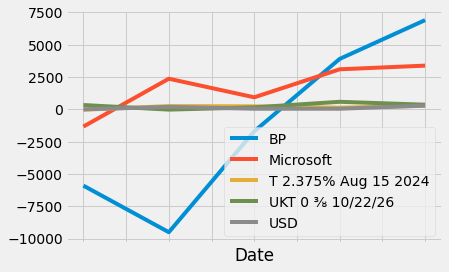

In [13]:
# Specify valuation start and end dates
monday_valuation = to_date("2022-03-07")
friday_valuation = to_date("2022-03-11")

# Obtain the Aggregation API (note this is currently only available in the LUSID Python Preview SDK)
aggregation_api = api_factory.build(la.AggregationApi)

# Create valuation request
valuation_request = lm.ValuationRequest(
    # Choose recipe to use
    recipe_id = lm.ResourceId(scope = module_scope, code = f"{module_code}Recipe"),
    # Specify metrics (also known as queryable keys) to report useful information
    metrics = [
        lm.AggregateSpec("Instrument/default/Name", "Value"),  # Instrument friendly name
        lm.AggregateSpec("Analytic/default/ValuationDate", "Value"), # Date on which valuation is performed
        lm.AggregateSpec("Holding/default/Units", "Value"), # Number of units held
        lm.AggregateSpec("Quotes/Price", "Value"), # Instrument price retrieved from quote store
        lm.AggregateSpec("Instrument/Definition/DomCcy", "Value"), # Transaction currency
        lm.AggregateSpec("Holding/default/Cost", "Value"), # Cost in transaction currency
        lm.AggregateSpec("Valuation/Accrued", "Value"), # Interest accrued since bond purchased or last coupon date, whichever most recent
        lm.AggregateSpec("Valuation/PV", "Value"),  # PV in transaction currency
        lm.AggregateSpec("Valuation/PnL/Unrealised", "Value"), # PnL in transaction currency (PV - Cost)
        lm.AggregateSpec("Quotes/FxRate/DomPortfolio", "Value"), # FX rate between transaction and portfolio currencies
        lm.AggregateSpec("Holding/Cost/Pfolio", "Value"), # Cost normalised to portfolio currency
        lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Value"), # PV normalised to portfolio currency
        lm.AggregateSpec("Valuation/PnL/Unrealised/PfolioCcy", "Value"), # PnL normalised to portfolio currency
        lm.AggregateSpec("Valuation/PnL/UnrealisedMarket/PfolioCcy", "Value"), # How much of PnL comes from change in market price
        lm.AggregateSpec("Valuation/PnL/UnrealisedFX/PfolioCcy", "Value"), # How much of PnL comes from change in FX rate

    ],
    # Display in date order
    sort = [lm.OrderBySpec(
        key = "Analytic/default/ValuationDate",
        sort_order = "Ascending"
    )],
    # Identify portfolio to value
    portfolio_entity_ids = [lm.PortfolioEntityId(scope = module_scope, code = module_code)],
    # Value each day from Monday 7 March to Friday 11 March 2022 inclusive
    valuation_schedule = lm.ValuationSchedule(
        effective_from=to_date(monday_valuation).isoformat(), 
        effective_at=to_date(friday_valuation).isoformat()
    ),
)

# Get portfolio valuation
val_data = aggregation_api.get_valuation(valuation_request = valuation_request).data

# Turn valuation response into Pandas dataframe and show it
val_each_instrument_df = pd.DataFrame(val_data)
# Give columns friendlier names
val_each_instrument_df.rename(
    columns = {
        "Instrument/default/Name": "Instrument",
        "Analytic/default/ValuationDate": "Date",
        "Holding/default/Units": "Units",
        "Quotes/Price": "Price",
        "Instrument/Definition/DomCcy": "Txn currency",
        "Holding/default/Cost": "Cost in Txn currency",
        "Valuation/Accrued": "Total interest accrued",
        "Valuation/PV": "PV in Txn currency",
        "Valuation/PnL/Unrealised": "PnL in Txn currency",
        "Quotes/FxRate/DomPortfolio": "FX rate",
        "Holding/Cost/Pfolio": "Cost in GBP",
        "Valuation/PvInPortfolioCcy": "PV in GBP",
        "Valuation/PnL/Unrealised/PfolioCcy": "PnL in GBP",
        "Valuation/PnL/UnrealisedMarket/PfolioCcy": "PnL from market price",
        "Valuation/PnL/UnrealisedFX/PfolioCcy": "PnL from FX rate"
    },
    inplace = True,
)
val_each_instrument_df["Date"] = pd.to_datetime(val_each_instrument_df["Date"]).dt.date
try:
    display(val_each_instrument_df.drop("Aggregation/Errors", axis=1))

except:
    display(val_each_instrument_df)

# Drop GBP - no point in plotting
val_each_instrument_df = val_each_instrument_df[(val_each_instrument_df.Instrument != "GBP")]
fig, ax = plt.subplots()
ax.tick_params(labelbottom = False)
for label, grp in val_each_instrument_df.groupby("Instrument"):
    grp.plot(x = "Date", y = "PnL in GBP", ax = ax, label = label)

### 7.2 Valuing the whole portfolio each day

,Date,Cost in GBP,PV in GBP,PnL in GBP
0,2022-03-07,"121,000.00","114,073.60","-6,926.40"
1,2022-03-08,"121,000.00","114,293.71","-6,706.29"
2,2022-03-09,"121,000.00","120,668.14",-331.86
3,2022-03-10,"121,000.00","128,757.48","7,757.48"
4,2022-03-11,"121,000.00","132,207.61","11,207.61"


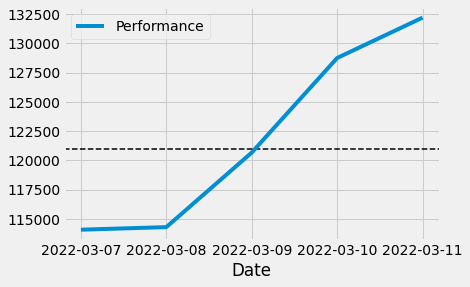

In [14]:
# Create valuation request
valuation_request = lm.ValuationRequest(
    recipe_id = lm.ResourceId(scope = module_scope, code = f"{module_code}Recipe"),
    metrics = [
        # It only makes sense to sum numeric values in the same currency
        lm.AggregateSpec("Analytic/default/ValuationDate", "Value"),          
        lm.AggregateSpec("Holding/Cost/Pfolio", "Sum"),
        lm.AggregateSpec("Valuation/PvInPortfolioCcy", "Sum"),
        lm.AggregateSpec("Valuation/PnL/Unrealised/PfolioCcy", "Sum"),
    ],
    # Group by valuation date in order to sum instrument positions and calculate a total for the portfolio each day
    group_by = ["Analytic/default/ValuationDate"],
    sort = [lm.OrderBySpec(
        key = "Analytic/default/ValuationDate",
        sort_order = "Ascending"
    )],
    portfolio_entity_ids = [lm.PortfolioEntityId(scope = module_scope, code = module_code)],
    valuation_schedule = lm.ValuationSchedule(
        effective_from=to_date(monday_valuation).isoformat(), 
        effective_at=to_date(friday_valuation).isoformat()
    ),
)

# Get portfolio valuation
val_data = aggregation_api.get_valuation(valuation_request = valuation_request).data

# Turn valuation response into Pandas dataframe
val_whole_portfolio_df = pd.DataFrame(val_data)
# Give columns friendlier names
val_whole_portfolio_df.rename(
    columns = {
        "Analytic/default/ValuationDate": "Date",
        "Sum(Holding/Cost/Pfolio)": "Cost in GBP",
        "Sum(Valuation/PvInPortfolioCcy)": "PV in GBP",
        "Sum(Valuation/PnL/Unrealised/PfolioCcy)": "PnL in GBP",
    },
    inplace = True,
)
# Remove time from datetime
val_whole_portfolio_df["Date"] = val_whole_portfolio_df["Date"].str[:10]

try:
    display(val_whole_portfolio_df.drop("Aggregation/Errors", axis=1))
except:
    display(val_whole_portfolio_df)

fig, ax = plt.subplots()
plt.axhline(y = 121000, color = 'black', linestyle = '--', linewidth = '1.5')
for label, grp in val_whole_portfolio_df.groupby("Cost in GBP"):
    grp.plot(x = "Date", y = "PV in GBP", ax = ax, label = "Performance")

## 8. A2B reports

### 8.1 Creating an A2B report

We can generate an A2B report using the same market data and recipe to understand precisely *how* the portfolio has changed in value between Monday 7 March and Friday 11 March 2022.

For each holding in a portfolio, an A2B report performs the following calculation, in both the holding and portfolio currencies:

`(Start Value + Flows + Gains + Carry) = End Value`

where:

* `Start Value` is the market value of the holding at the start of the window. This can be zero if, for example, you first transact in the underlying instrument during the window.
* `Flows` are transactions that result in increases or decreases in the quantity of the holding.
* `Gains` are capital gains or losses caused by market price or exchange rate fluctuations.
* `Carry` is income (for example, dividend or accrual) or expense (for example, management or transaction fee) activity.
* `End Value` is the market value of the holding at the end of the window.

In [15]:
# Generate A2B report using Python function equivalent to the LUSID GetA2BData API
a2b_report = transaction_portfolios_api.get_a2_b_data(
    scope = module_scope,
    code = module_code,
    from_effective_at = monday_valuation,
    to_effective_at = friday_valuation,
    recipe_id_scope = module_scope,
    recipe_id_code = f"{module_code}Recipe",
    property_keys=["Instrument/default/Name"]
)

# Transform to Pandas dataframe for better UX
a2b_report_df = lusid_response_to_data_frame(a2b_report)

# Retain only columns reporting portfolio currency totals
a2b_report_filtered_df = a2b_report_df.filter(items=[
    "properties.Instrument/default/Name.value.label_value",
    "currency",
    "start.portfolio_currency.total",
    "flows.portfolio_currency.total",
    "gains.portfolio_currency.total","carry.portfolio_currency.total",
    "end.portfolio_currency.total"
]
)

# Rename columns
a2b_report_filtered_df.rename(columns = {
    "properties.Instrument/default/Name.value.label_value": "Instrument Name",
    "start.portfolio_currency.total": "MarketValuePC (Start)",
    "flows.portfolio_currency.total": "FlowsPC",
    "gains.portfolio_currency.total": "CapGainsPC",
    "carry.portfolio_currency.total": "CarryPC",
    "end.portfolio_currency.total": "MarketValuePC (End)",
}, inplace = True,
)

# Show A2B report
a2b_report_filtered_df.sort_values(by=['currency'])

,Instrument Name,currency,MarketValuePC (Start),CapGainsPC,CarryPC,MarketValuePC (End)
0,GBP,GBP,"40,200.00",NaN,NaN,"40,200.00"
2,UKT 0 ⅜ 10/22/26,GBP,"10,134.01",24.00,0.41,"10,158.42"
3,BP,GBP,"44,100.00","12,800.00",NaN,"56,900.00"
1,USD,USD,"3,360.00",288.00,NaN,"3,648.00"
4,T 2.375% Aug 15 2024,USD,"3,609.59",309.00,1.39,"3,919.98"
5,Microsoft,USD,"12,670.00","4,711.20",NaN,"17,381.20"


### 8.2 Calculating aggregated column totals 

We can calculate aggregated column totals using the Pandas `sum()` function (note it only makes sense to sum columns normalised to the portfolio currency).

In [16]:
a2b_report_filtered_df.sum(numeric_only = True).to_frame().transpose()

,MarketValuePC (Start),CapGainsPC,CarryPC,MarketValuePC (End)
0,"114,073.60","18,132.20",1.80,"132,207.60"
